(c) 2023 Manuel Razo. This work is licensed under a [Creative Commons
Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
All code contained herein is licensed under an [MIT
license](https://opensource.org/licenses/MIT).

In [1]:
@load_pkg ActiveInference
# Import package to revise jlArchetype modules
using Revise

# Import library to handle iterations
import IterTools

# Import project package
import ActiveInference as AI

# Import basic math
import StatsBase
import Distributions
import Random

# Load plotting-related packages
using CairoMakie
import ColorSchemes
import Colors

# Activate backend
CairoMakie.activate!()

# Set Plotting style
AI.viz.theme_makie!()

# A tutorial on the free-energy framework for modelling perception and learning

This notebook accompanies a series of notes based on the [2017 paper by
Bogacz](https://www.sciencedirect.com/science/article/pii/S0022249615000759).

## Simplest example of perception

Let us imagine an organism that is trying to determine the radius of an object
$r$ based on the light intensity. We assume the organism has a receptor that
gives a noisy readout of the **log** light intensity $I$. Let us then define
$$
g(r) = \ln r^2 = 2 \ln r,
\tag{1}
$$
be the non-linear function that relates the size of the object to the
log-intensity.

**Note**: *In the paper, the author uses only $g(r) = r^2$, but acknowledges that
then using a Gaussian distribution is problematic as it can take negative
values. Thus, I added the log to transform the variable.*


Let us then assume that for an object of size $r$, the organism's noisy receptor
gives a noisy readout of the form
$$
I \mid r \sim \mathcal{N}\left(g(r), \Sigma^{(I)}_l \right),
\tag{2}
$$
where the subscript $l$ indicates parameters of the likelihood function. Given
this level of noise, the organism uses prior knowledge---acquired by experience
to encode its expectations on the size of the objects it perceives with this
particular receptor. This prior is of the form
$$
r \sim \mathcal{N}\left(\mu^{(r)}_p, \Sigma^{(r)}_p \right),
\tag{3}
$$
where the subscript $p$ represents "prior" information. Given a measurement, the
organism estimates the size of the object by computing Bayes' theorem
$$
\pi(r \mid I) = \frac{\pi(I \mid r) \pi(r)}{\pi(I)},
\tag{4}
$$
where the technical problem comes from computing the denominator
$$
\pi(I) = \int dr\; \pi(I \mid r) \pi(r).
\tag{5}
$$

Let us now assume that the organism gets to read out from its receptor a single
measurement:
- $I = 0.5$.

Furthermore, we assume the following parameters for the mean and variances:
- $\Sigma^{(I)}_l = 1$,
- $\mu^{(r)}_p = 3$,
- $\Sigma^{(r)}_p = 1$.

To be able to compute Eq. 4, we first need a way to compute the integral in
Eq. 5. Let us define a function to compute this integral via a simple numerical
quadrature. 

In [2]:
@doc raw"""
    quad_midpoint(f, a, b, N)

Numerically integrates function `f` from `a` to `b` with `N` points.

# Arguments
- `f::function`: 1D-real-valued function to be integrated.
- `a::Real`: Integration lower limit.
- `b::Real`: Integration upper limit.
- `N::Int`: Number of steps to take
"""
function quad_midpoint(f::Function, a::Real, b::Real, N::Int)
    # Define width of each bin
    h = (b - a) / N

    # Initialize value of integral
    int = 0.0

    # Loop through steps
    for k = 1:N
        # Define mid point for k-th iteration
        xₖ_mid = (b - a) * (2k - 1) / (2N) + a
        # Add value of bin to integral.
        int += h * f(xₖ_mid)
    end # for

    return int
end # function

quad_midpoint

Next, let us define a function to evaluate the posterior distribution we want
to evaluate.

In [3]:
@doc raw"""
`π_r_I(I::Real, r::Vector{<:Real}, Σₗ⁽ᴵ⁾::Real, μₚ⁽ʳ⁾::Real, Σₚ⁽ʳ⁾::Real; 
        g::Function=x -> log(x^2), N::Int=1000)`

Function to compute the posterior distribution π(r | I).

# Arguments
- `I::Real`: Value of the (log) intensity read by the detector.
- `r::Vector{<:Real}`: Object radius over which to evaluate the posterior dist.
- `Σᵣ::Real`: Value of the likelihood variance.
- `μₚ⁽ʳ⁾::Real`: Mean of the prior distribution of object radius size.
- `Σₚ⁽ʳ⁾::Real`: Variance of the prior distribution of object radius size.

## Optional Keyword Arguments
- `g::Function`: Non-linear function mapping form radius to detector readout.
- `N::Int`: Number of bins used to perform the integration for the evidence.
  Default = 1000.

# Returns
- `π(r|I)::Array{Float64}`: Array evaluating the posterior distribution at all
  values of `r`.
"""
function π_r_I(
    I::Real,
    r::Vector{<:Real},
    Σₗ⁽ᴵ⁾::Real,
    μₚ⁽ʳ⁾::Real,
    Σₚ⁽ʳ⁾::Real;
    g::Function=x -> log(x^2),
    N::Int=1000
)
    # Define prior distribution
    π_prior(x) = Distributions.pdf(Distributions.Normal(μₚ⁽ʳ⁾, √(Σₚ⁽ʳ⁾)), x)
    # Define likelihood distribution
    π_likelihood(x) = Distributions.pdf(Distributions.Normal(g(x), √(Σₗ⁽ᴵ⁾)), I)
    # Compute the evidence performing numerical integration
    π_evidence = quad_midpoint(
        y -> π_likelihood(y) * π_prior(y),
        r[1],
        r[end],
        N
    )
    # Evaluate posterior for each value of r
    return [π_prior(x) * π_likelihood(x) / π_evidence for x in r]
end # function

π_r_I

Having defined the function, let's look at the posterior distribution.

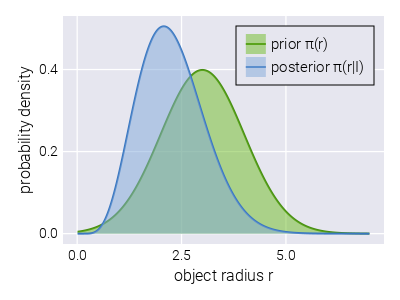

In [4]:
# Define ranges of r to evaluate
r = collect(LinRange(0.01, 7, 1000))

# Define parameters
I = 0.5
Σₗ⁽ᴵ⁾ = 1
μₚ⁽ʳ⁾ = 3
Σₚ⁽ʳ⁾ = 1

# Evaluate prior
π_prior = Distributions.pdf.(Ref(Distributions.Normal(μₚ⁽ʳ⁾, Σₚ⁽ʳ⁾)), r)
# Evaluate posterior
π_posterior = π_r_I(I, r, Σₗ⁽ᴵ⁾, μₚ⁽ʳ⁾, Σₚ⁽ʳ⁾)

# Extract colors
color_palette = AI.viz.colors()

# Initialize figure
fig = Figure(resolution=(400, 300))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="object radius r",
    ylabel="probability density"
)

# Plot prior distribution
lines!(
    ax,
    r,
    π_prior,
    label="prior π(r)",
    color=color_palette[:green]
)
fill_between!(
    ax,
    r,
    zeros(length(r)),
    π_prior,
    label="prior π(r)",
    color=(color_palette[:light_green], 0.5)
)

# Plot posterior distribution
lines!(
    ax,
    r,
    π_posterior,
    label="posterior π(r|I)",
    color=color_palette[:blue]
)

fill_between!(
    ax,
    r,
    zeros(length(r)),
    π_posterior,
    label="posterior π(r|I)",
    color=(color_palette[:light_blue], 0.5)
)

# Add legend
axislegend(ax, unique=true, merge=true)

fig

This computation shows how the organism would update the distribution encoding
its believes about the size of the object given freshly-taken information.

## Finding the most-likely feature value

The previous result is difficult to compute with neuronal or molecular
components. An alternative perspective is to compute the so-called MAP that
maximizes the posterior distribution $\pi(r \mid I)$. Therefore, our goal 
becomes to compute
$$
\phi = \max_r \pi(I \mid r) \pi(r),
\tag{6}
$$
where we ignore the denominator of Eq. 4 since it does not depend on the value
of $r$. Computing this MAP is equivalent to approximating the desired posterior
distribution $\pi(r \mid I)$ with a **much simpler** distribution
$$
q(r) \equiv \delta(r - \phi),
\tag{7}
$$
i.e., a delta function where $\phi$ sets the point where this function is equal
to one. To make our proposed approximate function in Eq. 7 to the true posterior
distribution, we must minimize the difference between both distributions as much
as possible. This is equivalent to minimizing the Kullback-Leibler (KL)
divergence
$$
q^*(r) = \min_{q(r)} D_{KL}(q(r)|| \pi(r \mid I)),
\tag{8}
$$
where the KL divergence is defined as
$$
D_{KL}(q(r)|| \pi(r \mid I)) \equiv
\int dr \; q(r) \ln \frac{q(r)}{\pi(r \mid I)}.
\tag{9}
$$
Since $q(r)$ is fully parametrized by the single parameter $\phi$, the 
minimization in Eq. 8 is equivalent to writing
$$
q_\phi^*(r) = \min_{\phi} D_{KL}(q_\phi(r)|| \pi(r \mid I)),
\tag{10}
$$
where we explicitly wrote $q_\phi(r)$ to highlight this parametric dependence.

Substituting Eq. 10 into this definition and carrying out some calculations, we
arrive at a result that
$$
\mathcal{F}[q_\phi(r)] \geq - \ln \pi(I),
\tag{11}
$$
where $\mathcal{F}$ is the so-called **variational free energy**, defined as
$$
\mathcal{F}[q_\phi(r)] \equiv \int dr \; \ln \frac{q_\phi(r)}{\pi(r, I)}.
\tag{12}
$$
The variational free energy therefore sets an upper bound on the Bayesian 
surprisal, $-\ln\pi(I)$. Computing this surprisal is the challenging part of why
performing the optimization in Eq. 6 is challenging. However, minimizing the
variational free energy over the space of possible distributions $q_\phi(r)$ is 
something computationally feasible. Therefore, our task becomes to minimize this
functional to approximate $q_\phi(r)$ as close to $\pi(r\mid I)$ as possible.

When substituting Eq. 7 into the variational free energy, we obtain
$$
\mathcal{F}[\delta(r - \phi)] = -\ln\pi(\phi, I) + C,
\tag{13}
$$
where $C$ is a constant that does not depend on $\phi$. Our goal of performing
the minimization in Eq. 8 then becomes equivalent to minimizing the variational
free energy over the parameters of the distribution $q_\phi(r)$. Since we
proposed $q_\phi(r)$ to be a $\delta$-function, this means that there is a
single parameter $\phi$ over which to minimize $\mathcal{F}$. To compute this
minimum, we must compute the derivative of $\mathcal{F}$ with respect to $\phi$,
obtaining
$$
\frac{d\mathcal{F}}{d\phi} = 
- \frac{I - g(\phi)}{\Sigma_l^{(I)}} \frac{dg}{d\phi} +
\frac{\phi - \mu^{(r)}_p}{\Sigma^{(\phi)}_p}.
\tag{13}
$$
Although solving for $\phi$ becomes challenging due to the non-linearity of $g$,
we can arrive at a minimum value by iteratively updating the value of $\phi$ 
over time using Euler's integration method. This is
$$
\phi(t + \Delta t) = \phi(t) - \frac{d \mathcal{F}}{d\phi}\Delta t.
\tag{14}
$$

Let's implement a function that computes this update. Note that for this
function we will require a closed-form solution for $dg/d\phi$. We could make
this more general by using an automatic differentiation tool.

In [5]:
@doc raw"""
    ϕ_opt_euler

Function to compute the MAP, i.e., the value of r that maximizes the posterior
π(r | I) using Euler's integration method.

# Arguments
- `ϕₒ::Real`: Initial estimate of the object dimensions.
- `I::Real`: Value of the (log) intensity read by the detector.
- `Σᵣ::Real`: Value of the likelihood variance.
- `μₚ⁽ʳ⁾::Real`: Mean of the prior distribution of object radius size.
- `Σₚ⁽ʳ⁾::Real`: Variance of the prior distribution of object radius size.

## Optional Keyword Arguments
- `g::Function`: Non-linear function mapping form radius to detector readout.
- `dg::Function`: Non-linear derivative of function mapping form radius to
  detector readout.
- `n_steps::Int`: Number of steps over which to perform integration. Default =
  1000.
- `Δt::AbstractFloat`: Step-size for the integration. Default = 0.01

# Returns
- `r::Array{Float64}`: Array with the trajectory of the estimated MAP.
- `time::Array{Float64}`: Array with the times where the integration was
  evaluated.
"""
function ϕ_opt_euler(
    ϕₒ::Real,
    I::Real,
    Σₗ⁽ᴵ⁾::Real,
    μₚ⁽ʳ⁾::Real,
    Σₚ⁽ʳ⁾::Real;
    g::Function=x -> log(x^2),
    dg::Function=x -> 2 / x,
    n_steps::Int=1_000,
    Δt::AbstractFloat=0.01
)
    # Initialize array to save values of r
    ϕ = Array{Float64}(undef, n_steps + 1)
    # Initialize array to save the time
    time = similar(ϕ)

    # Set initial value
    ϕ[1] = Float64(ϕₒ)
    time[1] = 0.0

    # Loop through iterations
    for t = 2:(n_steps+1)
        # Compute dF/dr
        dF_dϕ = (I - g(ϕ[t-1])) / Σₗ⁽ᴵ⁾ * dg(ϕ[t-1]) - (ϕ[t-1] - μₚ⁽ʳ⁾) / Σₚ⁽ʳ⁾
        # Update value of ϕ
        ϕ[t] = ϕ[t-1] + Δt * dF_dϕ
        # Update value of time
        time[t] = time[t-1] + Δt
    end # for

    return ϕ, time
end # function

ϕ_opt_euler

Let us now compute the value of $\phi$ over time.

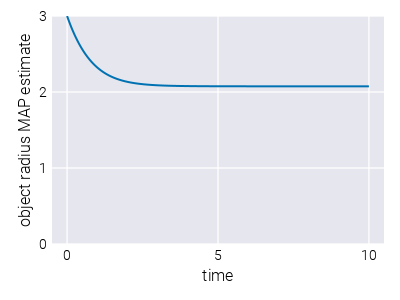

In [6]:
# Define parameters
ϕₒ = 3
I = 0.5
Σₗ⁽ᴵ⁾ = 1
μₚ⁽ʳ⁾ = 3
Σₚ⁽ʳ⁾ = 1

# Evaluate trajectory
ϕ_opt, time = ϕ_opt_euler(ϕₒ, I, Σₗ⁽ᴵ⁾, μₚ⁽ʳ⁾, Σₚ⁽ʳ⁾; n_steps=1_000)

# Initialize figure
fig = Figure(resolution=(400, 300))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="time",
    ylabel="object radius MAP estimate"
)

# Plot trajectory
lines!(ax, time, ϕ_opt)

ylims!(ax, [0, 3])

fig

Let's compare the final value with the value of the full posterior distribution.

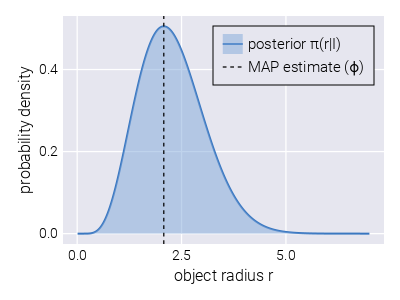

In [7]:
# Initialize figure
fig = Figure(resolution=(400, 300))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="object radius r",
    ylabel="probability density"
)

# Plot posterior distribution
lines!(
    ax,
    r,
    π_posterior,
    label="posterior π(r|I)",
    color=color_palette[:blue]
)

fill_between!(
    ax,
    r,
    zeros(length(r)),
    π_posterior,
    label="posterior π(r|I)",
    color=(color_palette[:light_blue], 0.5)
)

# Add final value
vlines!(
    ϕ_opt[end],
    linestyle=:dash,
    color=:black,
    label="MAP estimate (ϕ)"
)

# Add legend
axislegend(ax, unique=true, merge=true)

fig

Indeed, this simple Euler update converges to the MAP. Next, we will explore how
could a set of neurons implement this computation.

## A possible neural implementation

When thinking of how neurons could compute the MAP of the posterior
distribution, we can assume that the parameters $\mu_p^{(r)}$, $\Sigma_p^{(r)}$,
and $\Sigma_l^{(I)}$ are encoded in the connections between neurons, since, in
principle they have to last throughout the organisms life. Meanwhile, the values
of $r$ and other relevant variables are encoded in the activity of the neurons
that dynamically change depending on the inputs they receive.

To represent this computation via a neuronal network, it is useful to define the
two following quantities:
$$
\varepsilon_p^{(r)} \equiv \frac{\phi - \mu_p^{(r)}}{\Sigma_p^{(r)}},
\tag{10}
$$
and
$$
\varepsilon_l^{(I)} \equiv \frac{I - g(\phi)}{\Sigma_l^{(I)}} g'(\phi).
\tag{11}
$$
These quantities, which are the terms in Eq. 8 can be interpreted as the 
prediction errors. Eq. 10 represents *how much does the inferred size $r$ differ
from the prior expectation*. Eq. 11 equivalently represents *how much does the
measured intensity $I$ differ from the expected intensity value for a given size
of the object $r$. With these definitions, we can write the update rules for the
estimate of $r$ described in Eq. 9 as
$$
\dot{\phi} = \varepsilon_l^{(I)}g'(\phi) - \varepsilon_p^{(r)}.
\tag{12}
$$

Just as $r$ is dynamically encoded by the activity of a neuron, the value of the
two error predictions can also be dynamically encoded by the activity of
neurons. It is easy to show that their update rules take the form
$$
\dot{\varepsilon}_l^{(I)} = 
(I - g(\phi)) - 
\left(\Sigma_l^{(I)} \varepsilon_l^{(I)}\right),
\tag{13}
$$
and
$$
\dot{\varepsilon}_p^{(r)} = 
\left(\phi(t) - \mu_p^{(r)}\right) - 
\left(\Sigma_p^{(r)} \varepsilon_p^{(r)}\right).
\tag{14}
$$

The connection between neurons can then be represented as the following diagram.

![*fig*](./figs/neuronal_netowork_01.png)

where the node $1$ represents a constant input neuron. This is because we
assumed that the parameters are encoded in the connections, not the nodes.

Let us now write a function that computes these dynamics.

In [8]:
@doc raw"""
`ϕ_neuron_dynamics(init::Vector{<:Real}, I::Real, Σₗ⁽ᴵ⁾::Real, μₚ⁽ʳ⁾::Real, 
                    Σₚ⁽ʳ⁾::Real; g::Function=x -> log(x^2), 
                    dg::Function=x -> 2 / x, n_steps::Int=1_000, 
                    Δt::AbstractFloat=0.01)`

Function to integrate the dynamics of a simple neuronal system computing the MAP
of the posterior distribution π(r | I) using Euler's integration method.

# Arguments
- `init::Vector{<:Real}`: 3D array with the following values:
    - `r_init`: Initial estimate of object size.
    - `εₚ⁽ʳ⁾_init`: Initial estimate of prior prediction error.
    - `εₗ⁽ᴵ⁾_init`: Initial estimate of likelihood prediction error.
- `I::Real`: Value of the (log) intensity read by the detector.
- `Σᵣ::Real`: Value of the likelihood variance.
- `μₚ⁽ʳ⁾::Real`: Mean of the prior distribution of object radius size.
- `Σₚ⁽ʳ⁾::Real`: Variance of the prior distribution of object radius size.

## Optional Keyword Arguments
- `g::Function`: Non-linear function mapping form radius to detector readout.
- `dg::Function`: Non-linear derivative of function mapping form radius to
    detector readout.
- `n_steps::Int`: Number of steps over which to perform integration. Default =
    1000.
- `Δt::AbstractFloat`: Step-size for the integration. Default = 0.01
"""
function ϕ_neuron_dynamics(
    init::Vector{<:Real},
    I::Real,
    Σₗ⁽ᴵ⁾::Real,
    μₚ⁽ʳ⁾::Real,
    Σₚ⁽ʳ⁾::Real;
    g::Function=x -> log(x^2),
    dg::Function=x -> 2 / x,
    n_steps::Int=1_000,
    Δt::AbstractFloat=0.01
)
    # Extract initial values
    ϕ_init, εₚ⁽ʳ⁾_init, εₗ⁽ᴵ⁾_init = init

    # Initialize array to save values of neuronal activity
    ϕ = Array{Float64}(undef, n_steps + 1)
    εₚ⁽ʳ⁾ = similar(ϕ)
    εₗ⁽ᴵ⁾ = similar(ϕ)

    # Initialize array to save the time
    time = similar(ϕ)

    # Set initial value
    ϕ[1] = Float64(ϕ_init)
    εₚ⁽ʳ⁾[1] = Float64(εₚ⁽ʳ⁾_init)
    εₗ⁽ᴵ⁾[1] = Float64(εₗ⁽ᴵ⁾_init)
    time[1] = 0.0

    # Loop through iterations
    for t = 2:(n_steps+1)
        # Compute derivative for r neuron
        dϕ_dt = εₗ⁽ᴵ⁾[t-1] * dg(ϕ[t-1]) - εₚ⁽ʳ⁾[t-1]
        # Compute derivative for εₗ⁽ᴵ⁾ neuron
        dεₚ⁽ʳ⁾_dt = (ϕ[t-1] - μₚ⁽ʳ⁾) - Σₚ⁽ʳ⁾ * εₚ⁽ʳ⁾[t-1]
        # Compute derivative for εₚ⁽ʳ⁾ neuron
        dεₗ⁽ᴵ⁾_dt = (I - g(ϕ[t-1])) - Σₗ⁽ᴵ⁾ * εₗ⁽ᴵ⁾[t-1]

        # Update value of neurons
        ϕ[t] = ϕ[t-1] + Δt * dϕ_dt
        εₚ⁽ʳ⁾[t] = εₚ⁽ʳ⁾[t-1] + Δt * dεₚ⁽ʳ⁾_dt
        εₗ⁽ᴵ⁾[t] = εₗ⁽ᴵ⁾[t-1] + Δt * dεₗ⁽ᴵ⁾_dt

        # Update value of time
        time[t] = time[t-1] + Δt
    end # for

    return ϕ, εₚ⁽ʳ⁾, εₗ⁽ᴵ⁾, time
end # function

ϕ_neuron_dynamics

Let's now integrate the system over time

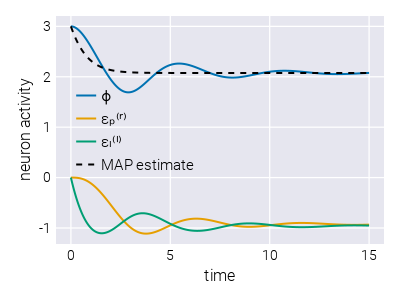

In [9]:
# Define parameters
init = [3, 0, 0]
I = 0.5
Σₗ⁽ᴵ⁾ = 1
μₚ⁽ʳ⁾ = 3
Σₚ⁽ʳ⁾ = 1

# Define number of steps
n_steps = 1_500

# Evaluate trajectory
sol = ϕ_neuron_dynamics(init, I, Σₗ⁽ᴵ⁾, μₚ⁽ʳ⁾, Σₚ⁽ʳ⁾; n_steps=n_steps)

# Evaluate trajectory
ϕ_opt = ϕ_opt_euler(init[1], I, Σₗ⁽ᴵ⁾, μₚ⁽ʳ⁾, Σₚ⁽ʳ⁾; n_steps=n_steps)

# Initialize figure
fig = Figure(resolution=(400, 300))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="time",
    ylabel="neuron activity"
)

# Define neuron labels
neuron_label = ["ϕ", "εₚ⁽ʳ⁾", "εₗ⁽ᴵ⁾"]

# Loop through labels
for (i, label) in enumerate(neuron_label)
    # Plot trajectory
    lines!(ax, sol[end], sol[i], label=label)
end # for

# Add trajectory for non-neuronal implementation
lines!(
    ax, ϕ_opt[2], ϕ_opt[1], label="MAP estimate", linestyle=:dash, color=:black
)

# Add legend
axislegend(ax, framevisible=false, position=:lc)

fig

This simple implementation indeed recovers the estimate of the MAP! Therefore,
we can implement a Bayesian computation with only 5 neurons.

## Scaling up the model of perception

Let's scale up the analysis to the case where there are two features
$$
\underline{\theta} = \begin{bmatrix}
\theta_1 & \theta_2
\end{bmatrix}^T,
\tag{15}
$$
identified from two observations
$$
\underline{x} = \begin{bmatrix}
x_1 & x_2 
\end{bmatrix}^T,
\tag{16}
$$

As for the 1D case, we will assume that the inputs $\underline{x}$ represent a
non-linear transform of the feature that the organism is trying to identify. For
simplicity, we will assume that for both features, the input is of the form
$$
x_i = h_i(\theta_i) = \ln \theta_i^2.
\tag{17}
$$
Furthermore, we will assume that the vector function
$\underline{g}(\underline{\theta})$ can be modulated by a set of parameters
$\underline{\underline{\Lambda}}$, such that
$$
\underline{g}(\underline{\theta}; \underline{\underline{\Lambda}}) = 
\underline{\underline{\Lambda}} \; \underline{h}(\underline{\theta}).
\tag{18}
$$

Following the extension from the 1D case, we assume that the receptors the organism uses to measure features $\underline{\theta}$ follow a distribution of the form
$$
\underline{x} \mid \underline{\theta} \sim 
\mathcal{N}(
    \underline{g}(\underline{\theta}; \underline{\underline{\Lambda}}),
    \underline{\underline{\Sigma}}_l^{(\underline{x})}
),
\tag{19}
$$
where $\underline{\underline{\Sigma}}_l^{(\underline{x})}$ is the covariance 
matrix of this multivariate Gaussian. Furthermore, the organism expects the 
features to reside within certain dimensions, as encoded in the prior
$$
\underline{\theta} \sim 
\mathcal{N}(
    \underline{\mu}_p^{(\underline{\theta})},
    \underline{\underline{\Sigma}}_p^{(\underline{\theta})}
).
\tag{20}
$$

Given a set of observations $\underline{x}$, the probability of the value of the
features $\underline{\theta}$ is computed as
$$
\pi(\underline{\theta} \mid \underline{x}) = 
\frac{
    \pi(\underline{x} \mid \underline{\theta}) \pi(\underline{\theta})
}
{
    \pi(\underline{x})
},
\tag{21}
$$
where the denominator is again computed from an integral, this time of the form
$$
\pi(\underline{x}) = \int d\theta_1 \int d\theta_2 \;
\pi(\underline{x} \mid \underline{\theta}) \pi(\underline{\theta}).
\tag{22}
$$

Let us perform this computation. Rather than programming our own
multi-dimensional quadrature procedure, we will use the `HCubature.jl` package
for this integration. Let's import it.

In [10]:
# Import package for multi-dimensional integration
import HCubature

Now, let's define a function that numerically computes the posterior 
distribution for this two-dimensional case.

In [11]:
@doc raw"""
`π_θ_x(x̲::Vector{<:Real}, θ̲::Matrix{<:Real}, Σ̲̲ₗ⁽ˣ⁾::Matrix{<:Real},
        μ̲ₚ⁽ᶿ⁾::Vector{<:Real}, Σ̲̲ₚ⁽ᶿ⁾::Matrix{<:Real};
        Λ̲̲::Matrix{Float64}=[[1.0 1.0]; [1.0 1.0]], h::Function=x -> log(x^2),
        n_grid::Int=100)`

Compute the posterior distribution π(θ|x) for parameters `θ` given data `x`.

# Arguments
- `x̲::Vector{<:Real}`: Observed data vector.
- `θ̲::Matrix{<:Real}`: Parameter vector to compute posterior for. Each column
  represents the range over which to evaluate the posterior for each parameter.
- `Σ̲̲ₗ⁽ˣ⁾::Matrix{<:Real}`: Covariance matrix function for data likelihood
- `μ̲ₚ⁽ᶿ⁾::Vector{<:Real}`: Mean vector function for prior on `θ`
- `Σ̲̲ₚ⁽ᶿ⁾::Matrix{<:Real}`: Covariance matrix function for prior on `θ`

## Optional Keyword Arguments
- `Λ̲̲::Matrix{Float64}`: Linear transformation matrix for likelihood
- `h::Function`: Link function for likelihood (default is log(x^2))  
- `n_grid::Int`: Number of grid points to use for numerical integration (default
  100)

# Returns
- `θ1_grid::Vector{Float64}`: Grid of first parameter values  
- `θ2_grid::Vector{Float64}`: Grid of second parameter values
- `π_posterior::Vector{Float64}`: Evaluated posterior values for each grid point

# Examples
```julia 
x = [1.0, 2.0]
θ = [0.5 2.0; 1.0 3.0]
Σl = x -> [1.0 0.0; 0.0 1.0] 

μp = θ -> [0.0; 0.0]
Σp = θ -> [1.0 0.0; 0.0 1.0]

θ1, θ2, π = π_θ_x(x, θ, Σl, μp, Σp)
```
"""
function π_θ_x(
    x̲::Vector{<:Real},
    θ̲::Matrix{<:Real},
    Σ̲̲ₗ⁽ˣ⁾::Matrix{<:Real},
    μ̲ₚ⁽ᶿ⁾::Vector{<:Real},
    Σ̲̲ₚ⁽ᶿ⁾::Matrix{<:Real};
    Λ̲̲::Matrix{Float64}=[[1.0 1.0]; [1.0 1.0]],
    h::Function=x -> log(x^2),
    n_grid::Int=100
)
    # Define prior distribution
    π_prior(x) = Distributions.pdf(
        Distributions.MvNormal(μ̲ₚ⁽ᶿ⁾, Σ̲̲ₚ⁽ᶿ⁾), x
    )
    # Define likelihood distribution
    π_likelihood(x) = Distributions.pdf(
        Distributions.MvNormal(Λ̲̲ * h.(x), Σ̲̲ₗ⁽ˣ⁾), x̲
    )
    # Compute the evidence by performing numerical integration
    π_evidence = HCubature.hcubature(
        x -> π_likelihood(x) * π_prior(x),
        eachrow(θ̲)...
    )

    # Define ranges where to evaluate posterior
    θ₁_range = LinRange(θ̲[:, 1]..., n_grid)
    θ₂_range = LinRange(θ̲[:, 2]..., n_grid)

    # Evaluate posterior for each grid point
    return (
        collect(θ₁_range),
        collect(θ₂_range),
        [
            π_likelihood(Array([x...])) * π_prior(Array([x...])) / π_evidence[1]
            for x in collect(IterTools.product(θ₁_range, θ₂_range))
        ])
end # function

π_θ_x

Given this function definition, let's evaluate the posterior for a set of 
observations.

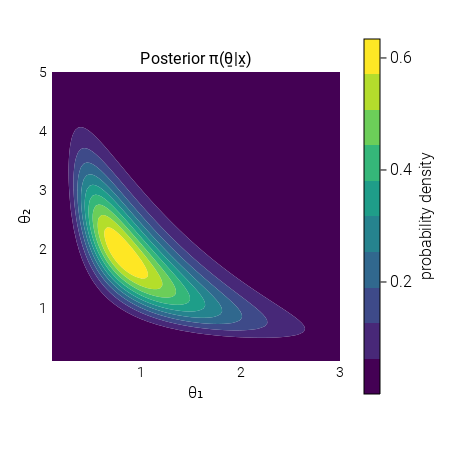

In [12]:
# Define observation values
x̲ = [0.5, 1.2]

# Define latent variable ranges to evaluate
θ̲ = [[0.1 0.1]; [3 5]]

# Define parameters
Σ̲̲ₗ⁽ˣ⁾ = [[1 0]; [0 1]]
μ̲ₚ⁽ᶿ⁾ = [1, 2]
Σ̲̲ₚ⁽ᶿ⁾ = [[1 0]; [0 1]]

# Evaluate posterior
posterior = π_θ_x(x̲, θ̲, Σ̲̲ₗ⁽ˣ⁾, μ̲ₚ⁽ᶿ⁾, Σ̲̲ₚ⁽ᶿ⁾)

# Initialize figure
fig = Figure(resolution=(450, 450))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="θ₁",
    ylabel="θ₂",
    title="Posterior π(θ̲|x̲)",
    aspect=AxisAspect(1)
)

# Plot contour on posterior distribution
co = contourf!(ax, posterior[1], posterior[2], posterior[3])

# Add colorbar
Colorbar(fig[1, 2], co, label="probability density")

fig

## A possible enural implementation

As with the 1D case, the computation of the MAP can be implemented with a
relatively simple neuronal system that follows a trajectory towards minimizing
the variational free energy $\mathcal{F}[q_\phi(\underline{\theta} -
\underline{\phi})]$. For this derivation, we generalize the definition of the
prediction errors defined in Eq. 10 and Eq. 11 to be of the form
$$
\underline{\varepsilon}_p^{(\underline{\theta})} \equiv
\left(\Sigma_{\underline{p}}^{(\underline{\theta})}\right)^{-1}
\left(\underline{\phi}-\underline{\mu}_p^{(\underline{\theta})}\right),
\tag{23}
$$
and
$$
\underline{\varepsilon}_l^{(\underline{x})} \equiv
\left(\Sigma_{\underline{l}}^{(\underline{x})}\right)^{-1}
\left(\underline{x} - \underline{g}(\underline{\phi})\right).
\tag{24}
$$

The dynamics of the $\underline{\phi}$ neurons take the form
$$
\underline{\dot{\phi}} = - \nabla_{\underline{\phi}} \mathcal{F} =
- \left(\underline{\varepsilon}_p^{(\underline{\theta})}
-\left(
    \underline{\underline{J}}_{\underline{\theta}}^{\underline{g}}
    \right)^T 
\underline{\varepsilon}_l^{(\underline{x})}\right),
\tag{25}
$$
where $\underline{\underline{J}}_{\underline{\theta}}^{\underline{g}}$ is the
Jacobian matrix of function $\underline{g}$ with respect to the
$\underline{\theta}$ variables. For the neurons representing the prediction
errors we have
$$
\dot{\varepsilon}_p^{(\theta)} = 
\left( \underline{\phi}-\mu_p^{(\underline{\theta})} \right) - 
\underline{\underline{\Sigma}}_p^{(\underline{\theta})} 
\underline{\varepsilon}_p^{(\underline{\theta})},
\tag{26}
$$
and
$$
\underline{\dot{\varepsilon}}_l^{(\underline{x})} = 
(\underline{x}-\underline{g}(\underline{\phi})) -
\underline{\underline{\Sigma}}_l^{(\underline{x})} 
\underline{\varepsilon}_l^{(\underline{x})}.
$$

Let's implement a function that integrates these dynamics.

In [35]:
@doc raw"""
φ_neuron_dynamics_2D( init::Vector{Float64}, x̲::Vector{Float64},
    Σ̲̲l(x)::Matrix{Float64}, μ̲p(θ)::Vector{Float64}, Σ̲̲p(θ)::Matrix{Float64};
    Λ̲̲::Matrix{Float64}=[1.0 1.0; 1.0 1.0], h::Function=log(x^2),
    dh::Function=2/x, n_steps::Int=1000, Δt::Float64=0.01 )

Simulate 2D neuronal dynamics estimating the MAP of the posterior distribution 
π(θ̲|x̲) over time.

# Arguments
- `init::Vector`: Initial activity state for all neurons [φ0, εp0, εl0]
- `x̲::Vector{Float64}`: Observed data 
- `Σ̲̲ₗ⁽ˣ⁾`: Covariance matrix for likelihood
- `μ̲ₚ⁽ᶿ⁾`: Mean vector for prior
- `Σ̲̲ₚ⁽ᶿ⁾`: Covariance matrix for prior

## Optional keyword arguments
- `Λ̲̲::Matrix{Float64}`: Linear transformation matrix  
- `h::Function`: Nonlinearity (default is log(x^2))
- `dh::Function`: Derivative of nonlinearity (default is 2/x)
- `n_steps::Int`: Number of time steps to simulate
- `Δt::Float64`: Time step size

# Returns
- `φ̲::Matrix{Float64}`: Neuronal activity over time
- `ε̲p::Matrix{Float64}`: Prior neuron activity over time  
- `ε̲l::Matrix{Float64}`: Likelihood neuron activity over time
- `time::Vector{Float64}`: Time points

# Examples
```julia
init = [0.1, 0.2, 0.3]  
x = [1.0, 2.0]
Σl = x -> [1.0 0.0; 0.0 1.0]
μp = [0.0, 0.0] 
Σp = [1.0 0.0; 0.0 1.0]

φ, εp, εl, t = φ_neuron_dynamics_2D(init, x, Σl, μp, Σp, n_steps=100)
```
"""
function ϕ_neuron_dynamics_2D(
    init::Vector,
    x̲::Vector{<:Real},
    Σ̲̲ₗ⁽ˣ⁾::Matrix{<:Real},
    μ̲ₚ⁽ᶿ⁾::Vector{<:Real},
    Σ̲̲ₚ⁽ᶿ⁾::Matrix{<:Real};
    Λ̲̲::Matrix{Float64}=[[1.0 1.0]; [1.0 1.0]],
    h::Function=x -> log(x^2),
    dh::Function=x -> 2 / x,
    n_steps::Int=1_000,
    Δt::AbstractFloat=0.01
)
    # Extract initial values
    ϕ_init, εₚ⁽ᶿ⁾_init, εₗ⁽ˣ⁾_init = init

    # Initialize array to save values of neuronal activity
    ϕ̲ = Matrix{Float64}(undef, 2, n_steps + 1)
    ε̲ₚ⁽ᶿ⁾ = similar(ϕ̲)
    ε̲ₗ⁽ˣ⁾ = similar(ϕ̲)

    # Initialize array to save time
    time = Vector{Float64}(undef, n_steps + 1)

    # Set initial values
    ϕ̲[:, 1] = Float64.(ϕ_init)
    ε̲ₚ⁽ᶿ⁾[:, 1] = Float64.(εₚ⁽ᶿ⁾_init)
    ε̲ₗ⁽ˣ⁾[:, 1] = Float64.(εₗ⁽ˣ⁾_init)
    time[1] = 0.0

    # Loop through iterations
    for t = 2:(n_steps+1)
        # Compute g(ϕ; Λ̲̲) = Λ̲̲ h̲(ϕ̲)
        g = Λ̲̲ * h.(ϕ̲[:, t-1])
        # Compute Jacobian matrix
        J̲̲ᵩᵍ = Λ̲̲ .* hcat(repeat([dh.(ϕ̲[:, t-1])], 2)...)'

        # Compute derivative for ϕ̲ neurons
        dϕ̲_dt = -(ε̲ₚ⁽ᶿ⁾[:, t-1] - J̲̲ᵩᵍ' * ε̲ₗ⁽ˣ⁾[:, t-1])

        # Compute derivative for ε̲ₚ⁽ᶿ⁾ neurons
        dε̲ₚ⁽ᶿ⁾_dt = (ϕ̲[:, t-1] - μ̲ₚ⁽ᶿ⁾) - (Σ̲̲ₚ⁽ᶿ⁾ * ε̲ₚ⁽ᶿ⁾[:, t-1])

        # Compute derivative for ε̲ₗ⁽ˣ⁾ neurons
        dε̲ₗ⁽ˣ⁾_dt = (x̲ - g) - (Σ̲̲ₗ⁽ˣ⁾ * ε̲ₗ⁽ˣ⁾[:, t-1])

        # Update value of neurons
        ϕ̲[:, t] = ϕ̲[:, t-1] + Δt .* dϕ̲_dt
        ε̲ₚ⁽ᶿ⁾[:, t] = ε̲ₚ⁽ᶿ⁾[:, t-1] + Δt .* dε̲ₚ⁽ᶿ⁾_dt
        ε̲ₗ⁽ˣ⁾[:, t] = ε̲ₗ⁽ˣ⁾[:, t-1] + Δt .* dε̲ₗ⁽ˣ⁾_dt

        # Update value of time
        time[t] = time[t-1] + Δt
    end # for

    # Return variables
    return ϕ̲, ε̲ₚ⁽ᶿ⁾, ε̲ₗ⁽ˣ⁾, time
end # function

ϕ_neuron_dynamics_2D

Having defined this function, let's integrate the dynamics for the same example
as above.

In [36]:
# Define initial conditions
ϕ_init = [2, 1]
εₚ⁽ᶿ⁾_init = [0, 0]
εₗ⁽ˣ⁾_init = [0, 0]

# Compile all initial conditions
init = [ϕ_init, εₚ⁽ᶿ⁾_init, εₗ⁽ˣ⁾_init]

# Define number of steps
n_steps = 1_500

# Evaluate trajectory
sol = ϕ_neuron_dynamics_2D(init, x̲, Σ̲̲ₗ⁽ˣ⁾, μ̲ₚ⁽ᶿ⁾, Σ̲̲ₚ⁽ᶿ⁾)

([2.0 2.0 … 0.8141041511555777 0.8138936406776077; 1.0 1.0 … 1.9214322169352422 1.9215010405091544], [0.0 0.01 … -0.18120651183529624 -0.1812534052053875; 0.0 -0.01 … -0.09257818233261904 -0.09243807833994043], [0.0 -0.008862943611198906 … -0.3911494171625949 -0.39118600064973996; 0.0 -0.0018629436111989063 … 0.3088200577129731 0.30878377947707236], [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.060000000000000005, 0.07, 0.08, 0.09  …  9.909999999999833, 9.919999999999833, 9.929999999999833, 9.939999999999833, 9.949999999999832, 9.959999999999832, 9.969999999999832, 9.979999999999832, 9.989999999999831, 9.999999999999831])

Now, we can display the phase portrait of the $\underline{\phi}$ neurons
overlayed with the contour lines of the full posterior distribution.

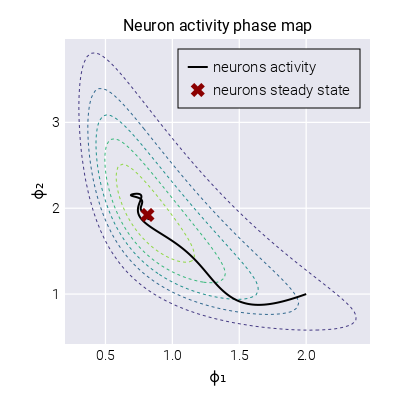

In [37]:
# Initialize figure
fig = Figure(resolution=(400, 400))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="ϕ₁",
    ylabel="ϕ₂",
    title="Neuron activity phase map",
    aspect=AxisAspect(1)
)

# Plot contour on posterior distribution
co = contour!(ax, posterior[1], posterior[2], posterior[3], linestyle=:dash)

# Add MAP neurons trajectory
lines!(
    ax, eachrow(sol[1])..., linewidth=2, label="neurons activity", color=:black
)

# Add final spot
scatter!(
    ax,
    sol[1][:, end]...,
    marker=:xcross,
    markersize=20,
    color=:darkred,
    label="neurons steady state"
)

axislegend(ax)

fig

The activity of the neuron seems to head towards the MAP. In principle, these
neurons are descending on the Variational Free Energy landscape towards the MAP.
Let's define a function that computes this free energy. Notice that the function
is completely equivalent to computing the posterior distribution, except that
we do not normalize the value since the 2D integral to compute the evidence is
not computed when computing the variational free energy.

In [38]:
@doc raw"""
`vfe_2D(x̲::Vector{<:Real}, θ̲::Matrix{<:Real}, Σ̲̲ₗ⁽ˣ⁾::Matrix{<:Real},
        μ̲ₚ⁽ᶿ⁾::Vector{<:Real}, Σ̲̲ₚ⁽ᶿ⁾::Matrix{<:Real};
        Λ̲̲::Matrix{Float64}=[[1.0 1.0]; [1.0 1.0]], h::Function=x -> log(x^2),
        n_grid::Int=100)`

Compute the Variational Free Energy F[qᵩ(θ̲)].

# Arguments
- `x̲::Vector{<:Real}`: Observed data vector.
- `θ̲::Matrix{<:Real}`: Parameter vector to compute posterior for. Each column
  represents the range over which to evaluate the posterior for each parameter.
- `Σ̲̲ₗ⁽ˣ⁾::Matrix{<:Real}`: Covariance matrix function for data likelihood
- `μ̲ₚ⁽ᶿ⁾::Vector{<:Real}`: Mean vector function for prior on `θ`
- `Σ̲̲ₚ⁽ᶿ⁾::Matrix{<:Real}`: Covariance matrix function for prior on `θ`

## Optional Keyword Arguments
- `Λ̲̲::Matrix{Float64}`: Linear transformation matrix for likelihood
- `h::Function`: Link function for likelihood (default is log(x^2))  
- `n_grid::Int`: Number of grid points to use for numerical integration (default
  100)

# Returns
- `θ1_grid::Vector{Float64}`: Grid of first parameter values  
- `θ2_grid::Vector{Float64}`: Grid of second parameter values
- `vfe::Vector{Float64}`: Evaluated variational free energy values for each grid
  point

# Examples
```julia 
x = [1.0, 2.0]
θ = [0.5 2.0; 1.0 3.0]
Σl = x -> [1.0 0.0; 0.0 1.0] 

μp = θ -> [0.0; 0.0]
Σp = θ -> [1.0 0.0; 0.0 1.0]

θ1, θ2, vfe = vfe_2D(x, θ, Σl, μp, Σp)
```
"""
function vfe_2D(
    x̲::Vector{<:Real},
    ϕ̲::Matrix{<:Real},
    Σ̲̲ₗ⁽ˣ⁾::Matrix{<:Real},
    μ̲ₚ⁽ᶿ⁾::Vector{<:Real},
    Σ̲̲ₚ⁽ᶿ⁾::Matrix{<:Real};
    Λ̲̲::Matrix{Float64}=[[1.0 1.0]; [1.0 1.0]],
    h::Function=x -> log(x^2),
    n_grid::Int=100
)
    # Define prior distribution
    π_prior(x) = Distributions.pdf(
        Distributions.MvNormal(μ̲ₚ⁽ᶿ⁾, Σ̲̲ₚ⁽ᶿ⁾), x
    )
    # Define likelihood distribution
    π_likelihood(x) = Distributions.pdf(
        Distributions.MvNormal(Λ̲̲ * h.(x), Σ̲̲ₗ⁽ˣ⁾), x̲
    )

    # Define ranges where to evaluate posterior
    θ₁_range = LinRange(θ̲[:, 1]..., n_grid)
    θ₂_range = LinRange(θ̲[:, 2]..., n_grid)

    # Evaluate posterior for each grid point
    return (
        collect(θ₁_range),
        collect(θ₂_range),
        [
            π_likelihood(Array([x...])) * π_prior(Array([x...]))
            for x in collect(IterTools.product(θ₁_range, θ₂_range))
        ])
end # function

vfe_2D (generic function with 1 method)

Let's plot again the trajectory of the $\phi$ neurons on top of the variational
free energy landscape.

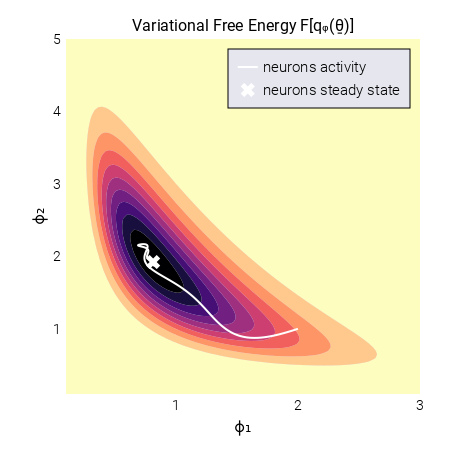

In [45]:
# Define observation values
x̲ = [0.5, 1.2]

# Define latent variable ranges to evaluate
ϕ̲ = [[0.1 0.1]; [3 5]]

# Evaluate posterior
vfe = vfe_2D(x̲, ϕ̲, Σ̲̲ₗ⁽ˣ⁾, μ̲ₚ⁽ᶿ⁾, Σ̲̲ₚ⁽ᶿ⁾)

# Initialize figure
fig = Figure(resolution=(450, 450))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="ϕ₁",
    ylabel="ϕ₂",
    title="Variational Free Energy F[qᵩ(θ̲)]",
    aspect=AxisAspect(1)
)

# Plot contour on posterior distribution
co = contourf!(ax, vfe[1], vfe[2], vfe[3], colormap=Reverse(:magma))

# Add MAP neurons trajectory
lines!(
    ax, eachrow(sol[1])..., linewidth=2, label="neurons activity", color=:white
)

# Add final spot
scatter!(
    ax,
    sol[1][:, end]...,
    marker=:xcross,
    markersize=20,
    color=:white,
    label="neurons steady state"
)

axislegend(ax,)

fig